# S08 — Espectrograma, tempo e onsets (librosa)
**Curso:** Programación Musical con Python — 2º Trimestre  
**Duración:** 1 sesión (≈ 1 hora)

## 🎯 Obxectivos
- Entender que é un **espectrograma** (tempo vs frecuencia vs enerxía).
- Debuxar un espectrograma con `librosa`.
- Estimar o **tempo (BPM)**.
- Detectar **onsets** (ataques/entradas) e visualizalos.
- Comparar 2 fragmentos/2 audios (diferentes tempos ou texturas).

> 🔥 “Wow” desta sesión: ver a música no plano tempo–frecuencia.


## 0) Setup (Colab)


In [1]:
!pip -q install librosa soundfile

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

from IPython.display import Audio, display

print("✅ librosa listo")



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
✅ librosa listo


## 1) Cargar audio (exemplo)

Imos usar un exemplo de librosa para non depender de subir ficheiros.
Se xa tes un audio do S07, tamén podes cargalo.


In [2]:
audio_path = librosa.ex("choice")  # exemplo con ritmo; tamén podes probar "trumpet"
y, sr = librosa.load(audio_path, sr=None)

print("sr:", sr, "| duración:", round(len(y)/sr, 2), "s")
display(Audio(y, rate=sr))


sr: 22050 | duración: 25.03 s


## 2) Espectrograma: STFT -> dB -> debuxo

Pasos:
1) STFT (transformada curta no tempo)
2) módulo (amplitude)
3) pasar a dB para ver mellor contrastes


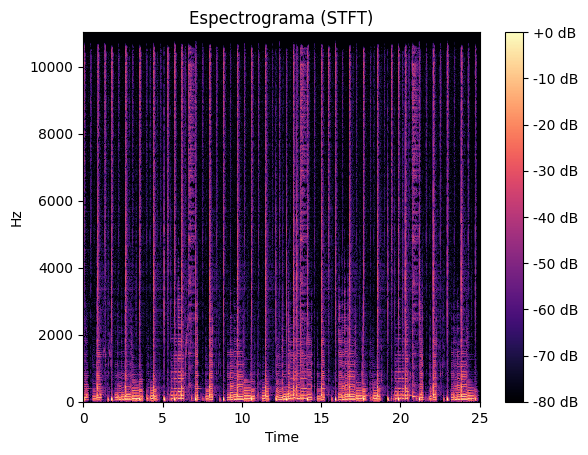

In [3]:
S = np.abs(librosa.stft(y))
S_db = librosa.amplitude_to_db(S, ref=np.max)

plt.figure()
librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma (STFT)")
plt.show()


### Variación: escala mel (máis “perceptiva”)

A escala mel agrupa frecuencias de forma máis próxima á percepción humana.


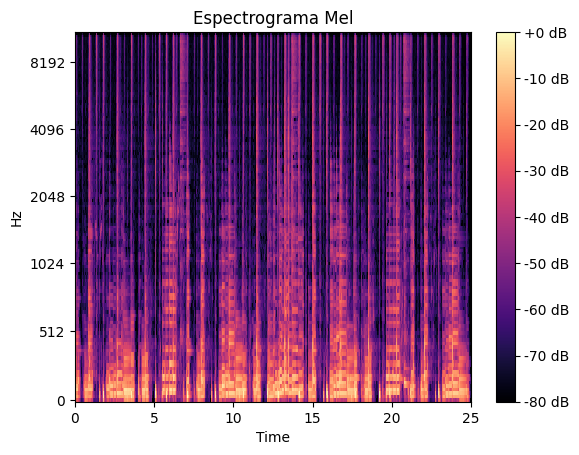

In [4]:
S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_mel_db = librosa.power_to_db(S_mel, ref=np.max)

plt.figure()
librosa.display.specshow(S_mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma Mel")
plt.show()


## 3) Estimar tempo (BPM)

`librosa.beat.beat_track` devolve unha estimación do tempo e a localización de beats.


In [5]:
tempo_bpm, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

tempo_bpm, beat_times[:10]


(array([135.99917763]),
 array([0.06965986, 0.48761905, 0.92879819, 1.36997732, 1.81115646,
        2.22911565, 2.69351474, 3.13469388, 3.57587302, 4.01705215]))

### Visualizar beats sobre a forma de onda


TypeError: unsupported format string passed to numpy.ndarray.__format__

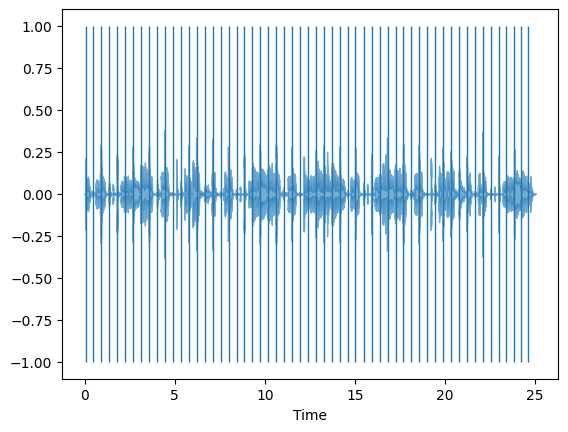

In [6]:
plt.figure()
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(beat_times, ymin=-1, ymax=1, linewidth=1)
plt.title(f"Beats estimados (BPM ~ {tempo_bpm:.1f})")
plt.xlabel("Tempo (s)")
plt.show()


## 4) Onsets (ataques)

Onsets = momentos de entrada/ataque (p.e. golpes, notas, sílabas).
Usamos un detector de onsets e visualizamos as marcas.


In [7]:
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

print("Onsets detectados:", len(onset_times))
onset_times[:10]


Onsets detectados: 98


array([0.06965986, 0.48761905, 0.60371882, 0.88235828, 0.92879819,
       1.36997732, 1.57895692, 1.78793651, 2.04335601, 2.20589569])

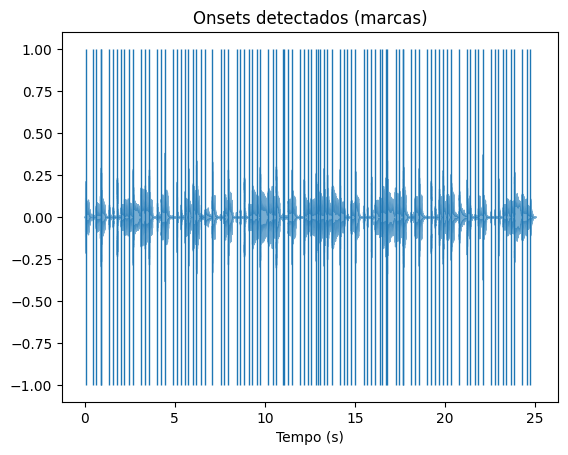

In [8]:
plt.figure()
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(onset_times, ymin=-1, ymax=1, linewidth=1)
plt.title("Onsets detectados (marcas)")
plt.xlabel("Tempo (s)")
plt.show()


## 5) Comparar dous fragmentos (ou dous audios)

Imos cortar 2 fragmentos e comparar:
- espectrogramas
- BPM estimado
- densidade de onsets

> Idea musical: un fragmento con moitos ataques parecerá máis “denso”.


In [9]:
def cortar(y, sr, inicio_s, fin_s):
    i0 = int(inicio_s * sr)
    i1 = int(fin_s * sr)
    return y[i0:i1]

# Escolle dous fragmentos distintos (cambia se queres)
fragA = cortar(y, sr, 0, 6)
fragB = cortar(y, sr, 6, 12)

display(Audio(fragA, rate=sr))
display(Audio(fragB, rate=sr))


In [10]:
def analizar_fragmento(yfrag, sr):
    tempo_bpm, _ = librosa.beat.beat_track(y=yfrag, sr=sr)
    onsets = librosa.onset.onset_detect(y=yfrag, sr=sr)
    onset_times = librosa.frames_to_time(onsets, sr=sr)
    return float(tempo_bpm), len(onset_times)

bpmA, onA = analizar_fragmento(fragA, sr)
bpmB, onB = analizar_fragmento(fragB, sr)

print("FragA -> BPM:", round(bpmA,1), "| onsets:", onA)
print("FragB -> BPM:", round(bpmB,1), "| onsets:", onB)


FragA -> BPM: 136.0 | onsets: 24
FragB -> BPM: 68.0 | onsets: 22


/var/folders/nb/sc6_k5jn76s2_byxg4c79pt00000gn/T/ipykernel_42113/3839786766.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(tempo_bpm), len(onset_times)


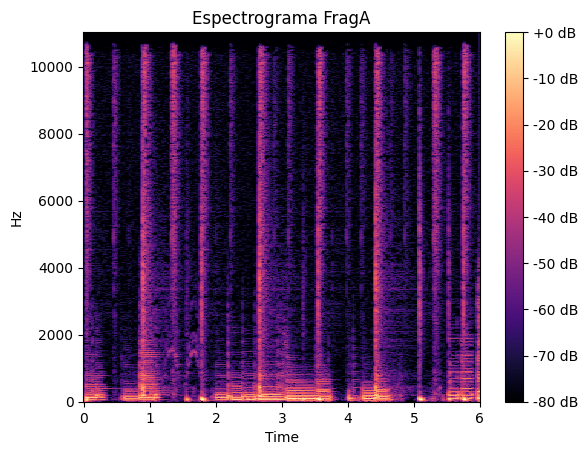

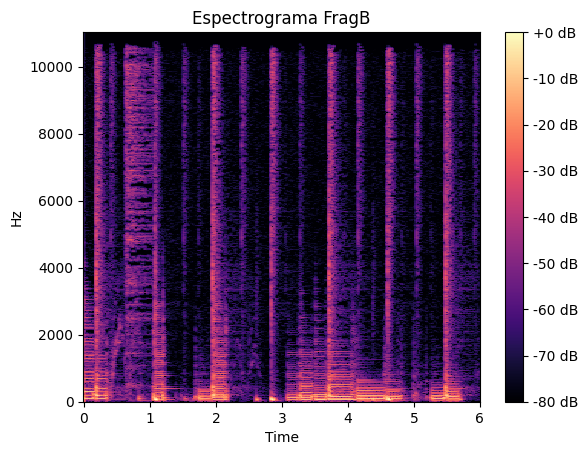

In [11]:
def espectrograma_db(yfrag, sr, titulo):
    S = np.abs(librosa.stft(yfrag))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
    plt.colorbar(format="%+2.0f dB")
    plt.title(titulo)
    plt.show()

espectrograma_db(fragA, sr, "Espectrograma FragA")
espectrograma_db(fragB, sr, "Espectrograma FragB")


## 🧩 Tarefa (avaliable)

### Parte A (técnica)
1) Carga un audio (exemplo de librosa ou propio)  
2) Debuxa **1 espectrograma** (STFT ou mel)  
3) Calcula o **BPM** estimado  
4) Detecta e debuxa **onsets** sobre a forma de onda  
5) Corta 2 fragmentos e compara:
   - BPM
   - nº de onsets

### Parte B (reflexión, 6–8 liñas)
- O BPM coincide co que percibes ao escoitar?
- Cal fragmento é máis “denso” e por que? (relación co nº de onsets e co espectrograma)

**Entrega:** enlace ao Colab + capturas das gráficas (ou gardadas como imaxes).


## 🧠 Ler código como partitura (checkpoint)
Organiza con comentarios:
- `# CARGA`
- `# ESPECTROGRAMA`
- `# BPM`
- `# ONSETS`
- `# COMPARACIÓN`
Así o notebook léese como un guión analítico.
